#### Install required libraries


In [1]:
! pip install git+https://github.com/TorkamaniLab/zoish.git
! pip install feature-engine category-encoders scikit-learn ipywidgets numpy pandas  --force-reinstall

Processing /Users/hjavedani/Documents/zoish
  Preparing metadata (setup.py) ... done
  Using cached e-1.4.5-py3-none-any.whl
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
  Using cached fasttreeshap-0.1.6-cp37-cp37m-macosx_13_0_x86_64.whl
  Using cached importlib_metadata-6.7.0-py3-none-any.whl.metadata (4.9 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached llvmlite-0.39.1-cp37-cp37m-macosx_10_9_x86_64.whl (25.5 MB)
  Using cached numba-0.56.4-cp37-cp37m-macosx_10_14_x86_64.whl (2.4 MB)
  Using cached numpy-1.21.6-cp37-cp37m-macosx_10_9_x86_64.whl (16.9 MB)
  Using cached packaging-23.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached pandas-1.3.5-cp37-cp37m-macosx_10_9_x86_64.whl (11.0 MB)
  Using cached psutil-5.9.8-cp36-abi3-macosx_10_9_x86_64.whl.metadata (21 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached scikit_learn-1.0.2-cp37-cp37m-

In [2]:
# Importing built-in libraries
import pandas as pd  # For data manipulation and analysis
import sys  # For accessing system-specific parameters and functions
import zoish  # Assuming it's a custom library for your project
import sklearn  # For machine learning models
import numpy  # For numerical computations

# Importing scikit-learn utilities for various ML tasks
from sklearn.compose import ColumnTransformer  # For applying transformers to columns
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer  # For handling missing data
from sklearn.metrics import (  # For evaluating the model
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
)
from sklearn.model_selection import GridSearchCV, train_test_split  # For CV and splitting dataset
from sklearn.pipeline import Pipeline  # For creating ML pipelines
from sklearn.preprocessing import StandardScaler,FunctionTransformer  # For feature scaling

# Importing other third-party libraries
from category_encoders import TargetEncoder  # For encoding categorical variables
from zoish.feature_selectors.shap_selectors import (  # For feature selection and visualization
    ShapFeatureSelector,
    ShapPlotFeatures,
)
import logging  # For logging events and errors

# Configuring logging settings
from zoish import logger  # Assuming it's a custom logger from zoish
logger.setLevel(logging.ERROR)  # Set logging level to ERROR


# Re-setting logging level (this seems redundant, consider keeping only one)
logger.setLevel(logging.ERROR)

# Printing versions of key libraries for debugging and documentation
print(f'Python version : {sys.version}')
print(f'zoish version : {zoish.__version__}')
print(f'sklearn version : {sklearn.__version__}')
print(f'pandas version : {pd.__version__}')  # Using the alias for pandas
print(f'numpy version : {numpy.__version__}')


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Python version : 3.7.8 (default, Feb 27 2023, 18:11:31) 
[Clang 14.0.0 (clang-1400.0.29.202)]
zoish version : 5.0.3
sklearn version : 1.0.2
pandas version : 1.3.5
numpy version : 1.21.6


#### Example: Audiology (Standardized) Data Set
###### https://archive.ics.uci.edu/ml/datasets/Audiology+%28Standardized%29


#### Read data


In [3]:
urldata = "https://archive.ics.uci.edu/ml/machine-learning-databases/lymphography/lymphography.data"
urlname = "https://archive.ics.uci.edu/ml/machine-learning-databases/lung-cancer/lung-cancer.names"
# column names
col_names = [
    "class",
    "lymphatics",
    "block of affere",
    "bl. of lymph. c",
    "bl. of lymph. s",
    "by pass",
    "extravasates",
    "regeneration of",
    "early uptake in",
    "lym.nodes dimin",
    "lym.nodes enlar",
    "changes in lym.",
    "defect in node",
    "changes in node",
    "special forms",
    "dislocation of",
    "exclusion of no",
    "no. of nodes in",

]

data = pd.read_csv(urldata,names=col_names)
data.head()


,class,lymphatics,block of affere,bl. of lymph. c,bl. of lymph. s,by pass,extravasates,regeneration of,early uptake in,lym.nodes dimin,lym.nodes enlar,changes in lym.,defect in node,changes in node,special forms,dislocation of,exclusion of no,no. of nodes in
3,4,2,1,1,1,1,1,2,1,2,2,2,4,8,1,1,2,2
2,3,2,1,1,2,2,1,2,1,3,3,2,3,4,2,2,2,2
3,3,2,2,2,2,2,2,2,1,4,3,3,4,8,3,2,2,7
3,3,1,1,1,1,2,1,2,1,3,3,4,4,4,3,1,2,6
2,3,1,1,1,1,1,1,1,1,2,2,4,3,5,1,2,2,1


#### Define labels and train-test split


In [4]:


data.loc[(data["class"] == 1) | (data["class"] == 2), "class"] = 0
data.loc[data["class"] == 3, "class"] = 1
data.loc[data["class"] == 4, "class"] = 2
data["class"] = data["class"].astype(int)

#### Train test split


In [5]:
X = data.loc[:, data.columns != "class"]
y = data.loc[:, data.columns == "class"]

y= y['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33,  random_state=42
)

#### Defining the feature pipeline steps:
Here, we use an untuned XGBClassifier model with the ShapFeatureSelector.In the next section, we will repeat the same process but with a tuned XGBClassifier. The aim is to demonstrate that a better estimator can yield improved results when used with the ShapFeatureSelector.


In [6]:
estimator_for_feature_selector = SVC(gamma='auto',probability=True)
estimator_for_feature_selector.fit(X_train.values, y_train)
shap_feature_selector = ShapFeatureSelector(
    model=estimator_for_feature_selector, 
    num_features=5, 
    cv = 5, 
    scoring='accuracy', 
    direction='maximum', 
    n_iter=10, 
    algorithm='auto',        
    predict_proba_params={},
    faster_kernelexplainer=True,
    # if the model is not tree based or not supposrted by treeexplainaer or
    # users want to intentiany used KernelExplainer then max_retries_for_explainer=1
    max_retries_for_explainer=1,

)
        

# Assuming X_train is a pandas DataFrame

# Define pre-processing for numeric columns (float and integer types)
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Define pre-processing for categorical features
categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', TargetEncoder(handle_missing='return_nan'))])

# Function to convert the output to a DataFrame
def to_dataframe(X, numeric_features, categorical_features):
    transformed_cols = list(numeric_features) + list(categorical_features)
    return pd.DataFrame(X, columns=transformed_cols)

# Combine preprocessing into one column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


# Feature Selection using ShapSelector 
feature_selection = shap_feature_selector 

# Classifier model
classifier =  SVC(gamma='auto',probability=True)

# Include to_dataframe function in pipeline
pipeline = Pipeline(
    steps=[
    ('preprocessor', preprocessor),
    ('to_dataframe', FunctionTransformer(to_dataframe, kw_args={'numeric_features': numeric_features, 'categorical_features': categorical_features})),
    ('feature_selection',shap_feature_selector),
    ('classifier', classifier)
    ]
    )

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on test data
y_test_pred = pipeline.predict(X_test)

# Output first 10 predictions
print(y_test_pred[:10])

ERROR:zoish.feature_selectors.shap_selectors:Attempt 1: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 2: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 1: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 2: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 1: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 2: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 1: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 2: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 1: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 2: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 1: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 2: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 1: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 2: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 1: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 2: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 1: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 2: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 1: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 2: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 1: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 2: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 1: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

ERROR:zoish.feature_selectors.shap_selectors:Attempt 2: Shap TreeExplainer could not be used: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'> , after max try KernelExplainer will be tried instead !


  0%|          | 0/99 [00:00<?, ?it/s]

[0 0 1 0 0 0 0 0 0 0]


#### Check performance of the Pipeline


In [7]:

print("F1 score : ")
print(f1_score(y_test, y_test_pred,average='micro'))
print("Classification report : ")
print(classification_report(y_test, y_test_pred))
print("Confusion matrix : ")
print(confusion_matrix(y_test, y_test_pred))



F1 score : 
0.46938775510204084
Classification report : 
              precision    recall  f1-score   support

           0       0.45      0.81      0.58        21
           1       0.55      0.43      0.48        14
           2       0.00      0.00      0.00        14

    accuracy                           0.47        49
   macro avg       0.33      0.41      0.35        49
weighted avg       0.35      0.47      0.38        49

Confusion matrix : 
[[17  4  0]
 [ 8  6  0]
 [13  1  0]]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


#### Shap related plots

feature_selector.importance_df.shape[0] 17
feature_selector.num_features 5


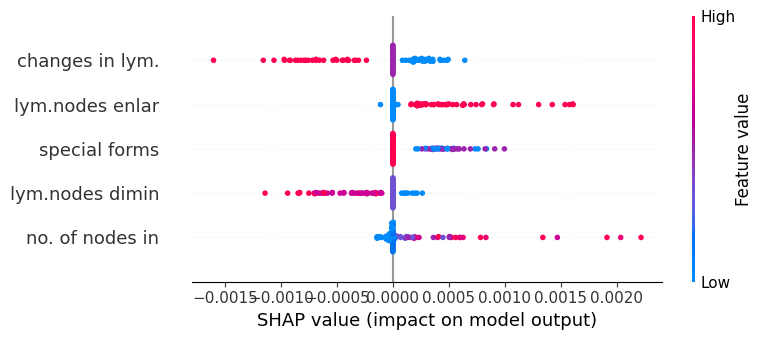

In [8]:

# Plot the feature importance
plot_factory = ShapPlotFeatures(shap_feature_selector) 
plot_factory.summary_plot()


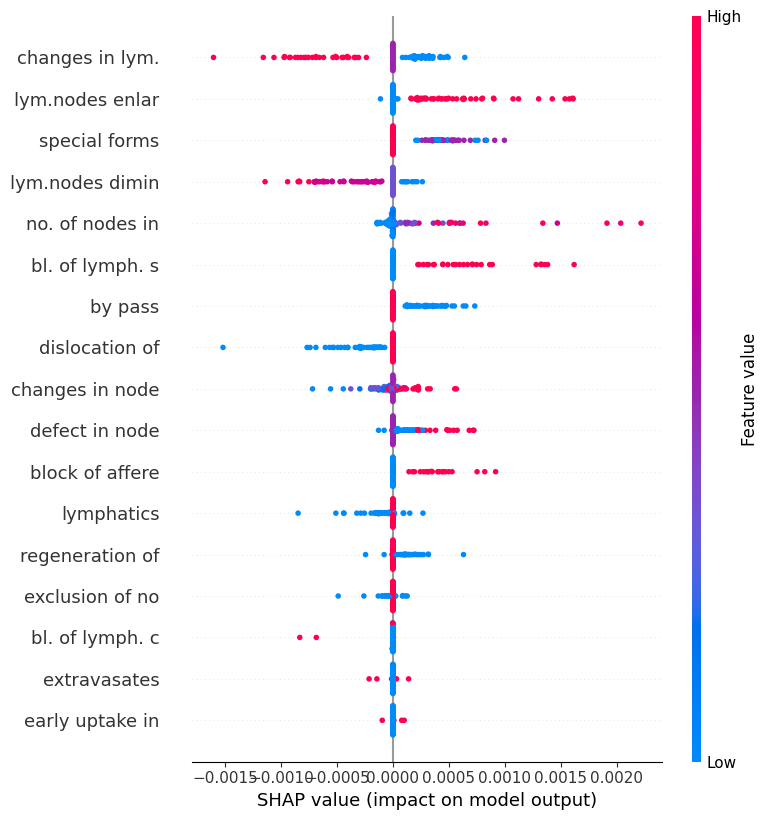

In [9]:
plot_factory.summary_plot_full()

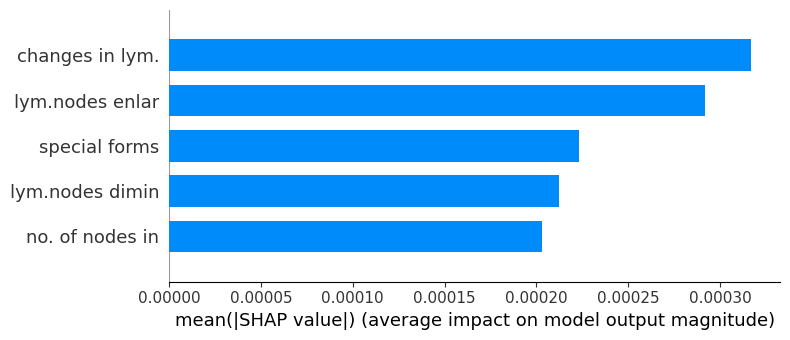

In [10]:

# Plot the feature importance
plot_factory.bar_plot()

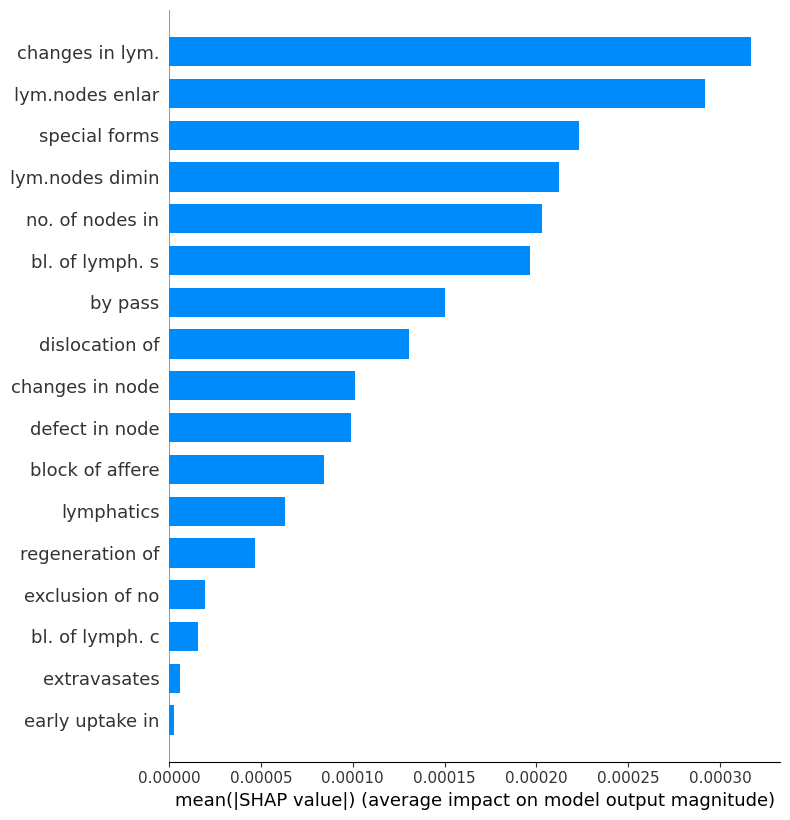

In [11]:
plot_factory.bar_plot_full()

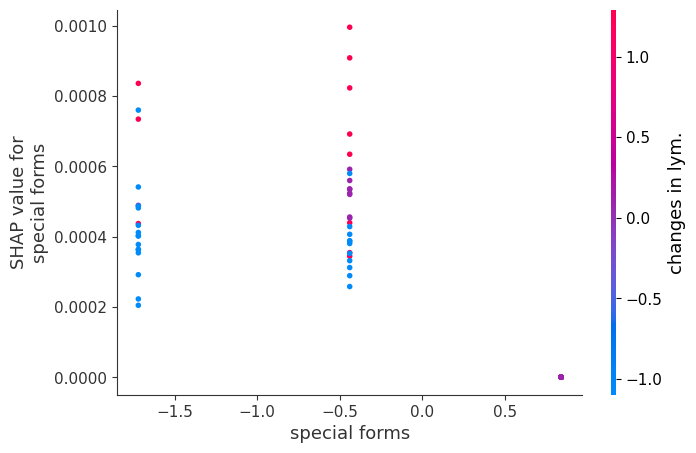

In [12]:
plot_factory.dependence_plot('special forms')